# Import libraries

In [1]:
#%matplotlib notebook


In [2]:
# ! pip install termcolor

In [3]:
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from termcolor import colored

# Function utils


In [4]:
"""
This function extract the bits from the results of the peak extract after the pattern match. 
It counts the number of 'subpeaks' between each larger peak. 
"""

def retrieve_bits_from_peaks(peaks, sub_peaks):
    ops = ""
    for idx, peak in enumerate(peaks[:-1]):
        next_peak = peaks[idx+1]
        # Check the number of subpeaks between two main peaks
        num_sub_peaks = len(sub_peaks[(sub_peaks > peak) & ((sub_peaks < next_peak))])
        # All windows start by a "1" and the other 4 bits are unknown
        ops += "1xxxx"
        # After the 5th peak the rest of operations are squares "0"
        if num_sub_peaks > 5:
            num_squares = num_sub_peaks - 5
            for _ in range(num_squares):
                ops += "0"  
    # Final opeations outside the loop
    ops += 'xxxxxx'
    return ops

In [5]:
def plot_trace_interval(data, start=0, end=None, ylim=None):
    if end == None:
        end = len(data)
    if ylim != None: 
        plt.ylim(ylim)   
    interval = data[start:end]
    plt.plot([*range(start, end, 1)], interval)
    plt.show()

In [6]:
def count_retrived_bits(retrieved_bits):
    return retrieved_bits.count('x'), retrieved_bits.count('1'), retrieved_bits.count('0')

# Load traces

In [ ]:
!wget https://github.com/victormico/mbedtls-rsa-inprogress/raw/master/husky-stm32f3/traces/1T_RSA_MBEDTLS_HUSKY_STM32_VMB.zip -P traces
!unzip traces/1T_RSA_MBEDTLS_HUSKY_STM32_VMB.zip -d traces

In [7]:
cwd = os.getcwd()
trace_path = os.path.join(cwd, "traces", "1T_RSA_MBEDTLS_HUSKY_STM32_VMB.npy")
trace = np.load(trace_path)

In [8]:
num_samples = len(trace)
num_samples

10920000

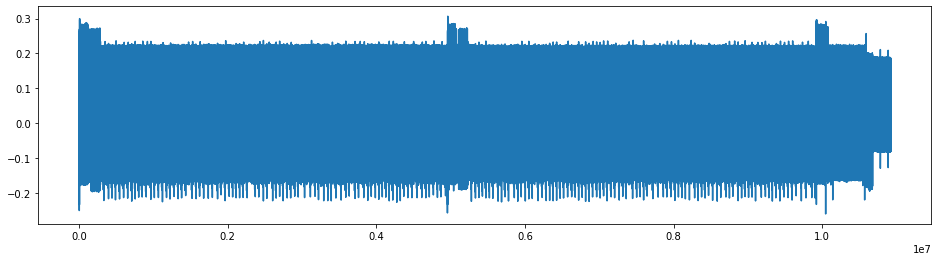

In [14]:
plt.rcParams["figure.figsize"] = (16,4)
#plt.rcParams["figure.figsize"] = (9,3)
plt.plot(trace)


## Preprocess and explore data

We filter the traces with a lowpass filter. 

In [10]:
weight = 100
weight_1 = weight + 1


result = np.array(trace)
for i in range(1,num_samples):
    result[i] = (result[i] + weight * result[i-1]) / weight_1
i = num_samples - 2
while i >= 0:
    result[i] = (result[i] + weight * result[i + 1]) / weight_1
    i-=1


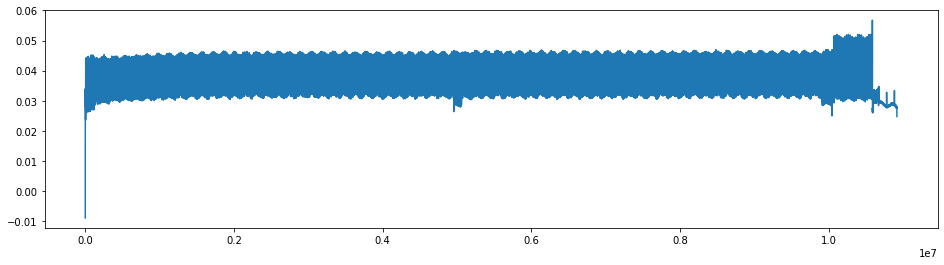

In [15]:
plt.plot(result)

In [47]:
lp_trace_path = trace_path.replace('.npy', '+LP(100).npy')

with open(lp_trace_path, 'wb') as f:
    np.save(f, np.array(result))

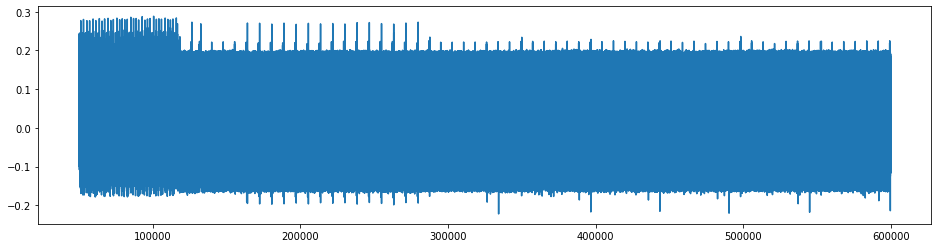

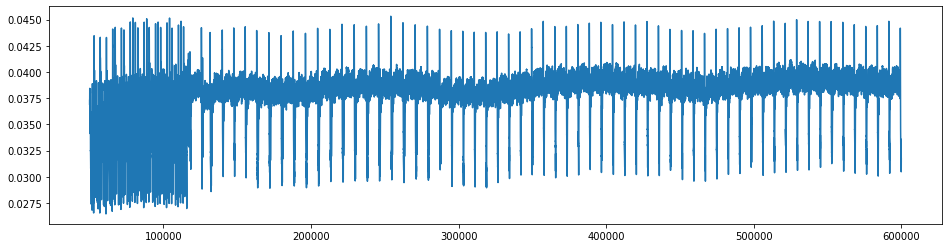

In [16]:
start = int(0.5e5)
end = int(6e5)
plot_trace_interval(trace, start, end)
plot_trace_interval(result, start, end)


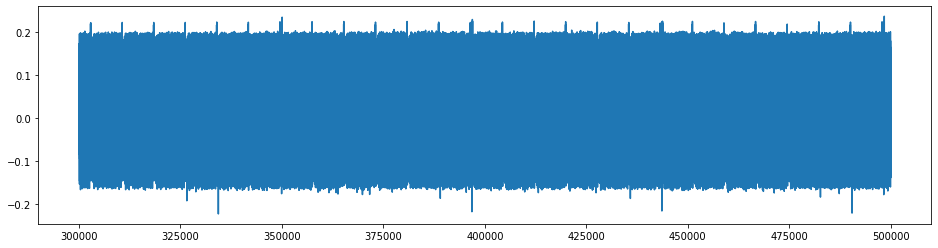

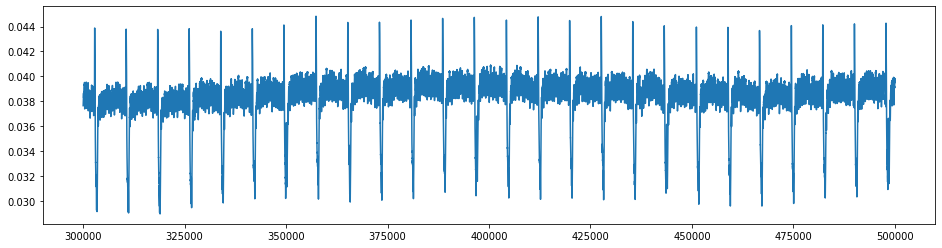

In [17]:
start = int(3e5)
end = int(5e5)
plot_trace_interval(trace, start, end)
plot_trace_interval(result, start, end)

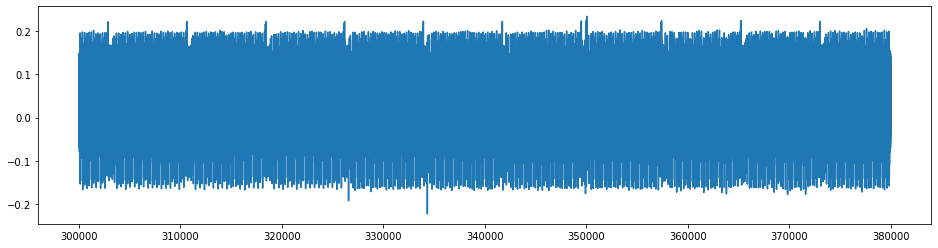

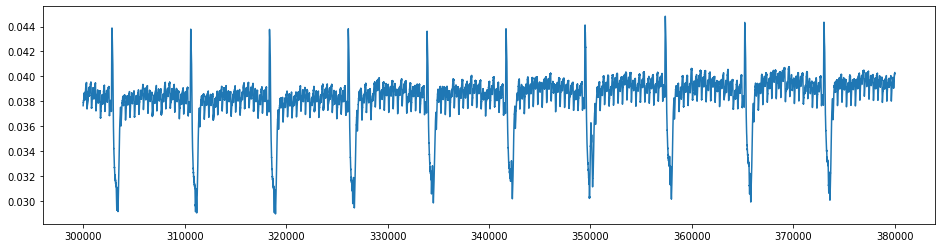

In [18]:
start = int(30e4)
end = int(38e4)
plot_trace_interval(trace, start, end)
plot_trace_interval(result, start, end)

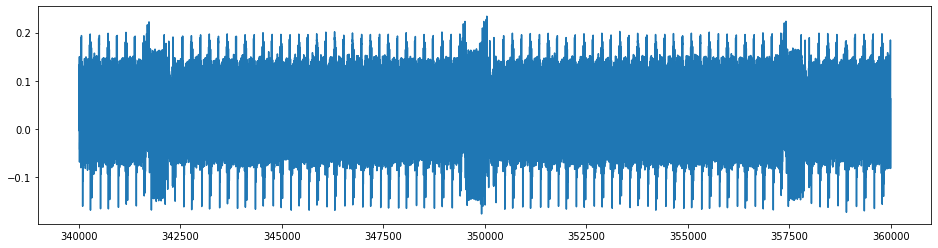

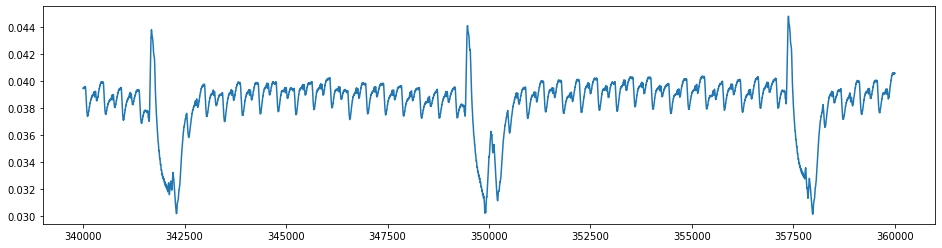

In [19]:
start = int(34e4)
end = int(36e4)
plot_trace_interval(trace, start, end)
plot_trace_interval(result, start, end)

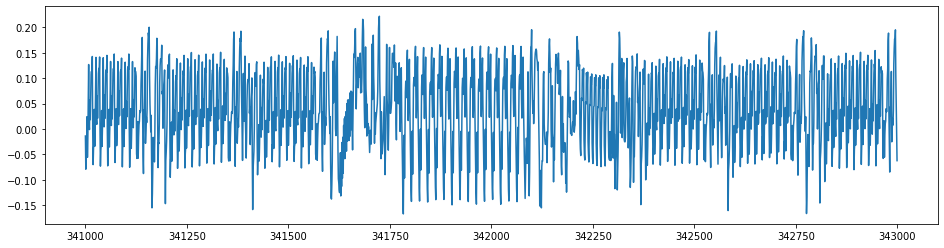

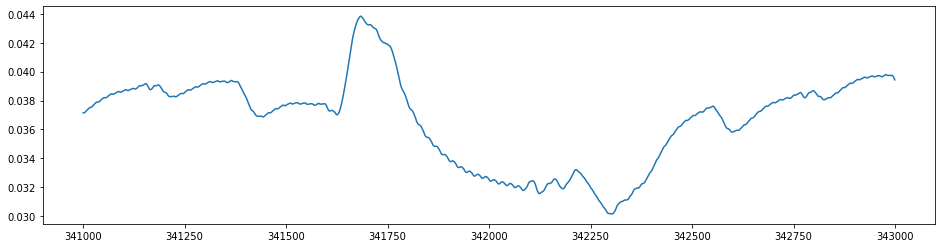

In [20]:
start = int(341000)
end = int(343000)
plot_trace_interval(trace, start, end)
plot_trace_interval(result, start, end)

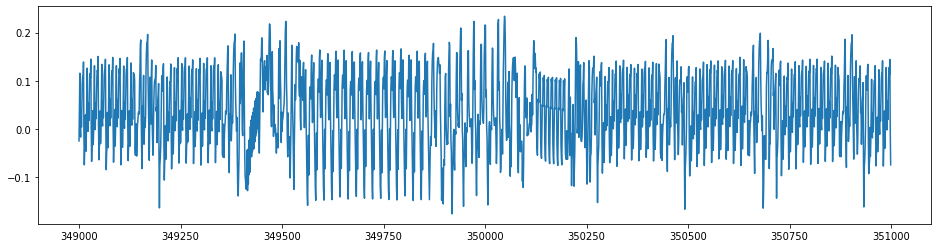

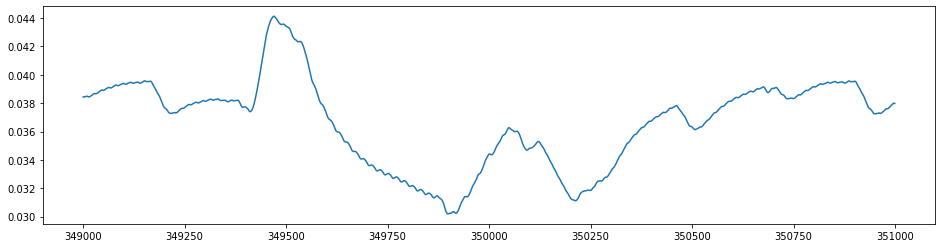

In [21]:
start = int(349000)
end = int(351000)
plot_trace_interval(trace, start, end)
plot_trace_interval(result, start, end)

This operation looks different from the others, lets conduct a pattern match to find out

# Pattern match with all the trace

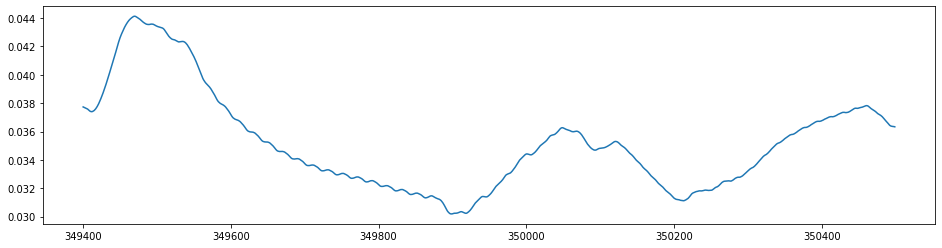

In [22]:
pattern_start = 349400
patern_end = 350500
pattern = result[pattern_start:patern_end]

plot_trace_interval(result, pattern_start, patern_end)

In [23]:
pattern_lenght = len(pattern)
pattern_lenght

1100

In [26]:
import numpy as np
import scipy.stats
result_length = len(result)-pattern_lenght
result_pattern_match = [0]*result_length
for i in tnrange(result_length):
    result_pattern_match[i] = scipy.stats.pearsonr(result[i:pattern_lenght+i], pattern)[0] 



C:\Users\thor9\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


  0%|          | 0/10918900 [00:00<?, ?it/s]

In [48]:
pattern_match_trace_path = lp_trace_path.replace('.npy', '+Pattern_match(349400-350500).npy')

with open(pattern_match_trace_path, 'wb') as f:
    np.save(f, np.array(result_pattern_match))

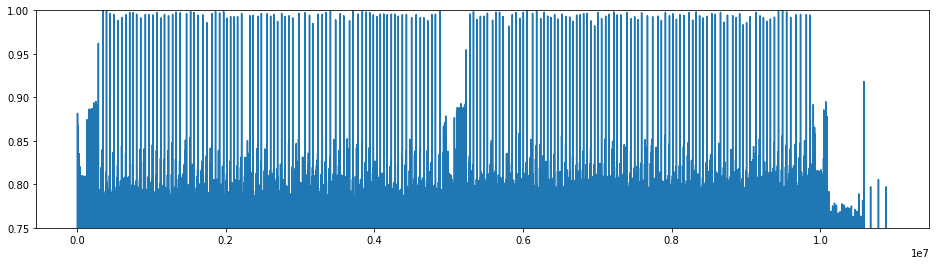

In [27]:
plot_trace_interval(result_pattern_match,ylim=[0.75,1])

In [28]:
dp_interval = result_pattern_match[0:5000000]
dq_interval = result_pattern_match[5000000:10000000]


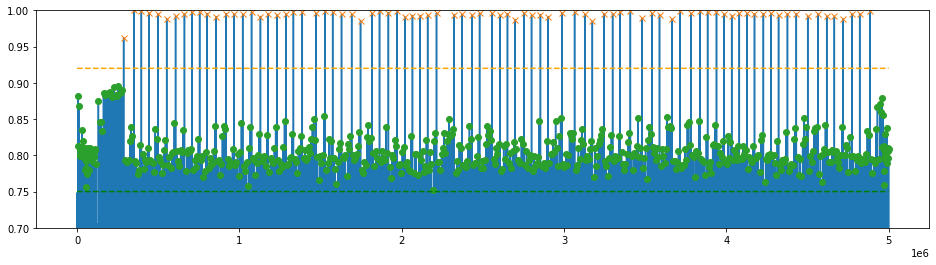

In [29]:
x = np.array(dp_interval)
h_peak = 0.92
h_sub_peak = 0.75
dp_peaks, _ = find_peaks(x, height=h_peak)
dp_sub_peaks, _ = find_peaks(x, height=[h_sub_peak,h_peak])
plt.ylim([0.7,1])
plt.plot(x)
plt.plot(dp_peaks, x[dp_peaks], "x")
plt.plot(dp_sub_peaks, x[dp_sub_peaks], "o")
plt.plot(np.full(shape=len(x), fill_value=h_peak), "--", color="orange")
plt.plot(np.full(shape=len(x), fill_value=h_sub_peak), "--", color="green")
plt.show()

In [30]:
dp_retrieved_bits = retrieve_bits_from_peaks(dp_peaks, dp_sub_peaks)
dp_retrieved_bits

'1xxxx001xxxx1xxxx1xxxx01xxxx01xxxx01xxxx01xxxx1xxxx1xxxx1xxxx01xxxx001xxxx1xxxx01xxxx01xxxx01xxxx1xxxx01xxxx01xxxx1xxxx01xxxx000001xxxx01xxxx1xxxx01xxxx001xxxx01xxxx0001xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx01xxxx000000001xxxx1xxxx001xxxx1xxxx00001xxxx1xxxx1xxxx1xxxx01xxxx1xxxx01xxxx1xxxx000001xxxx00001xxxx001xxxx1xxxx0001xxxx01xxxx1xxxx001xxxx0001xxxx001xxxx1xxxx00001xxxx1xxxx0001xxxx01xxxx1xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx1xxxx1xxxx01xxxx01xxxx0001xxxx001xxxx01xxxx1xxxx01xxxx01xxxx1xxxx00xxxxxx'

In [31]:
dp_peaks

array([ 287062,  349400,  396314,  443125,  497767,  552367,  607090,
        661706,  708486,  755297,  802075,  856691,  919165,  966001,
       1020558, 1075183, 1129803, 1176672, 1231402, 1286015, 1332901,
       1387523, 1473440, 1528015, 1574821, 1629430, 1691826, 1746476,
       1816685, 1863477, 1918072, 1972647, 2019443, 2066266, 2113105,
       2159955, 2214534, 2323708, 2370541, 2433066, 2479950, 2557964,
       2604833, 2651718, 2698533, 2753175, 2799997, 2854636, 2901468,
       2987263, 3065234, 3127698, 3174496, 3244785, 3299436, 3346239,
       3408708, 3478921, 3541397, 3588252, 3666297, 3713078, 3783227,
       3837927, 3884704, 3939342, 3986213, 4032998, 4079833, 4126633,
       4173437, 4228087, 4274940, 4321751, 4376415, 4431055, 4501368,
       4563734, 4618401, 4665284, 4720078, 4774642, 4821481, 4884044],
      dtype=int64)

In [32]:
ret_x, ret_1, ret_0 = count_retrived_bits(dp_retrieved_bits)

print('x: '+ str(ret_x))
print('1: '+ str(ret_1))
print('0: '+ str(ret_0))

print('Percentage of bits: '+ str((ret_1+ret_0)/512))


x: 338
1: 83
0: 91
Percentage of bits: 0.33984375


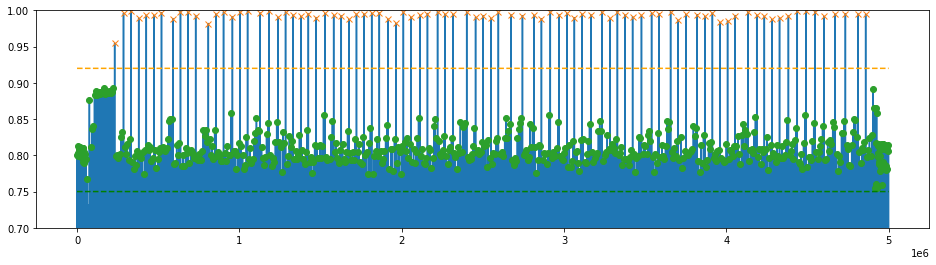

In [33]:
x = np.array(dq_interval)
h_peak = 0.92
h_sub_peak = 0.75
dq_peaks, _ = find_peaks(x, height=h_peak)
dq_sub_peaks, _ = find_peaks(x, height=[h_sub_peak,h_peak])
plt.ylim([0.7,1])
plt.plot(x)
plt.plot(dq_peaks, x[dq_peaks], "x")
plt.plot(dq_sub_peaks, x[dq_sub_peaks], "o")
plt.plot(np.full(shape=len(x), fill_value=h_peak), "--", color="orange")
plt.plot(np.full(shape=len(x), fill_value=h_sub_peak), "--", color="green")
plt.show()

In [34]:
dq_retrieved_bits = retrieve_bits_from_peaks(dq_peaks, dq_sub_peaks)
dq_retrieved_bits

'1xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx0001xxxx1xxxx1xxxx1xxxx00001xxxx1xxxx1xxxx01xxxx1xxxx1xxxx00001xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx1xxxx1xxxx1xxxx01xxxx1xxxx001xxxx1xxxx1xxxx000001xxxx01xxxx1xxxx1xxxx1xxxx00001xxxx0001xxxx0001xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx01xxxx0001xxxx1xxxx1xxxx1xxxx1xxxx01xxxx001xxxx1xxxx0001xxxx1xxxx1xxxx0001xxxx1xxxx1xxxx1xxxx1xxxx1xxxx00001xxxx01xxxx1xxxx1xxxx1xxxx01xxxx01xxxx01xxxx01xxxx01xxxx0001xxxx001xxxx00001xxxxxxxxxx'

In [35]:
dq_peaks

array([ 231730,  286294,  333062,  379879,  426700,  473450,  520323,
        590481,  637250,  684065,  730854,  808858,  855673,  902585,
        957155, 1003927, 1050695, 1128648, 1183196, 1237857, 1284616,
       1331377, 1378207, 1425000, 1471765, 1526376, 1580962, 1627786,
       1674651, 1721466, 1768347, 1815214, 1862161, 1916717, 1963542,
       2010386, 2057266, 2111885, 2158738, 2221119, 2267901, 2314687,
       2400505, 2455166, 2501951, 2548797, 2595589, 2673669, 2743911,
       2814024, 2860860, 2915494, 2970155, 3016921, 3063711, 3110514,
       3165112, 3235300, 3282070, 3328916, 3375699, 3422575, 3477118,
       3539514, 3586408, 3656592, 3703378, 3750242, 3820426, 3867247,
       3914035, 3960897, 4007658, 4054591, 4132599, 4187248, 4234041,
       4280905, 4327703, 4382341, 4436898, 4491510, 4546143, 4600752,
       4670941, 4733344, 4811242, 4858179], dtype=int64)

In [36]:
ret_x, ret_1, ret_0 = count_retrived_bits(dq_retrieved_bits)

print('x: '+ str(ret_x))
print('1: '+ str(ret_1))
print('0: '+ str(ret_0))

print('Percentage of bits: '+ str((ret_1+ret_0)/512))


x: 354
1: 87
0: 71
Percentage of bits: 0.30859375


# Known key analysis

## 1st exponentiation

In [37]:
def compare(a, b):
    res = 0
    ret_a = ""
    ret_b = ""
    for x, y in zip(a, b):
        if x == y:
            ret_a += colored(x, 'green')
            ret_b += colored(y, 'green')
            res += 1
        elif x != 'x' and y != 'x':
            ret_a += colored(x, 'red')
            ret_b += colored(y, 'red')
        else:
            ret_a += x
            ret_b += y
    print(ret_a)
    print(ret_b)

    return res

In [38]:
dp = int("C1ACF567564274FB07A0BBAD5D26E2983C94D22288ACD763FD8E5600ED4A702DF84198A5F06C2E72236AE490C93F07F83CC559CD27BC2D1CA488811730BB5725", 16)
dp_bin = bin(dp)[2:]
dp_bin

'11000001101011001111010101100111010101100100001001110100111110110000011110100000101110111010110101011101001001101110001010011000001111001001010011010010001000101000100010101100110101110110001111111101100011100101011000000000111011010100101001110000001011011111100001000001100110001010010111110000011011000010111001110010001000110110101011100100100100001100100100111111000001111111100000111100110001010101100111001101001001111011110000101101000111001010010010001000100000010001011100110000101110110101011100100101'

In [39]:
compare(dp_retrieved_bits, dp_bin)/len(dp_bin)

1xxxx001xxxx1xxxx1xxxx01xxxx01xxxx01xxxx01xxxx1xxxx1xxxx1xxxx01xxxx001xxxx1xxxx01xxxx01xxxx01xxxx1xxxx01xxxx01xxxx1xxxx01xxxx000001xxxx01xxxx1xxxx01xxxx001xxxx01xxxx0001xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx01xxxx000000001xxxx1xxxx001xxxx1xxxx00001xxxx1xxxx1xxxx1xxxx01xxxx1xxxx01xxxx1xxxx000001xxxx00001xxxx001xxxx1xxxx0001xxxx01xxxx1xxxx001xxxx0001xxxx001xxxx1xxxx00001xxxx1xxxx0001xxxx01xxxx1xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx1xxxx1xxxx01xxxx01xxxx0001xxxx001xxxx01xxxx1xxxx01xxxx01xxxx1xxxx00xxxxxx
1100000110101100111101010110011101010110010000100111010011111011000001111010000010111011101011010101110100100110111000101001100000111100100101001101001000100010100010001010110011010111011000111111110110001110010101100000000011101101010010100111000000101101111110000100000110011000101001011111000001101100001011100111001000100011011010101110010010010000110010010011111100000111111110000011110011000101010110011100110100100111101111000010110100011100101001001000100010000001000101110011000

0.33984375

In [40]:
def get_window_values(d):
    known_bits = []
    i = 0
    try:
        while True:
            b = d[i]
            if (b == '0'):
                i += 1
            else:
                known_bits.append(int(d[i+1:i+5],2))
                i += 5
    except IndexError:
        pass
    except ValueError:
        pass
    print(known_bits)

In [41]:
get_window_values(dp_bin)

[8, 10, 9, 13, 6, 13, 6, 0, 3, 4, 15, 8, 14, 0, 7, 13, 10, 7, 2, 11, 1, 3, 14, 2, 3, 2, 1, 1, 5, 3, 7, 8, 15, 13, 1, 9, 6, 13, 5, 4, 12, 6, 15, 0, 0, 9, 1, 2, 15, 11, 7, 12, 1, 11, 5, 9, 2, 9, 3, 14, 15, 12, 14, 8, 5, 9, 9, 4, 3, 11, 8, 6, 1, 9, 2, 1, 0, 1, 12, 8, 7, 10, 7, 2]


## 2nd exponentiation

In [42]:
dq = int("4959CBF6F8FEF750AEE6977C155579C7D8AAEA56749EA28623272E4F7D0592AF7C1F1313CAC9471B5C523BFE592F517B407A1BD76C164B93DA2D32A383E58357", 16) #dq
dq_bin = bin(dq)[2:]
dq_bin

'1001001010110011100101111110110111110001111111011110111010100001010111011100110100101110111110000010101010101010111100111000111110110001010101011101010010101100111010010011110101000101000011000100011001001110010111001001111011111010000010110010010101011110111110000011111000100110001001111001010110010010100011100011011010111000101001000111011111111100101100100101111010100010111101101000000011110100001101111010111011011000001011001001011100100111101101000101101001100101010001110000011111001011000001101010111'

In [43]:
compare(dq_retrieved_bits, dq_bin)/len(dq_bin)

1xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx0001xxxx1xxxx1xxxx1xxxx00001xxxx1xxxx1xxxx01xxxx1xxxx1xxxx00001xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx1xxxx1xxxx1xxxx01xxxx1xxxx1xxxx1xxxx01xxxx1xxxx001xxxx1xxxx1xxxx000001xxxx01xxxx1xxxx1xxxx1xxxx00001xxxx0001xxxx0001xxxx1xxxx01xxxx01xxxx1xxxx1xxxx1xxxx01xxxx0001xxxx1xxxx1xxxx1xxxx1xxxx01xxxx001xxxx1xxxx0001xxxx1xxxx1xxxx0001xxxx1xxxx1xxxx1xxxx1xxxx1xxxx00001xxxx01xxxx1xxxx1xxxx1xxxx01xxxx01xxxx01xxxx01xxxx01xxxx0001xxxx001xxxx00001xxxxxxxxx
10010010101100111001011111101101111100011111110111101110101000010101110111001101001011101111100000101010101010101111001110001111101100010101010111010100101011001110100100111101010001010000110001000110010011100101110010011110111110100000101100100101010111101111100000111110001001100010011110010101100100101000111000110110101110001010010001110111111111001011001001011110101000101111011010000000111101000011011110101110110110000010110010010111001001111011010001011010011001010100011100000111

0.30919765166340507

In [44]:
get_window_values(dq_bin)

[2, 5, 3, 2, 15, 6, 15, 15, 11, 11, 5, 5, 11, 3, 2, 13, 14, 5, 5, 7, 3, 1, 14, 8, 5, 7, 4, 5, 3, 4, 3, 10, 1, 0, 8, 1, 2, 12, 7, 3, 11, 13, 6, 2, 5, 13, 14, 15, 3, 3, 9, 6, 2, 1, 8, 11, 7, 4, 1, 11, 15, 9, 9, 7, 5, 7, 6, 0, 14, 0, 11, 10, 13, 6, 6, 2, 12, 3, 11, 1, 10, 9, 4, 12, 15, 6, 10, 7]
